In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
from collections import namedtuple
import numpy as np
import matplotlib
from itertools import count
import random
import math
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


In [30]:
replay = namedtuple('replay',('state','action','reward','next_state'))

class Replay_buffer():
    
    def __init__(self , buffer_size):
        self.buffer_size = buffer_size
        self.buffer = np.zeros(  [buffer_size] , dtype = replay)
        self.index = 0
        self.cur_size = 0
        
    def push(self,experience):
        self.buffer[self.index] = experience
        self.index = (self.index+1)%self.buffer_size
        if self.cur_size < self.buffer_size:
            self.cur_size += 1
    def sample(self,batch_size):
        sample_index = np.random.choice(np.arange(self.cur_size),size=batch_size,replace=False)
        return self.buffer[sample_index]

    
class DQN(nn.Module): #Shallow QN
    
    def __init__(self):
        super(DQN,self).__init__()
        self.L1 = nn.Linear(4,50)
        self.out = nn.Linear(50,2)
    
    def forward(self,x):
        x = F.relu(self.L1(x))
        x = self.out(x)
        return x

In [31]:
num_epsoide = 500

network = DQN()
target_network = DQN()
target_network.load_state_dict(network.state_dict())
loss_fn = torch.nn.MSELoss(size_average=True)
buffer = Replay_buffer(4000)
EPS_START = 0.999
EPS_END = 0.05
EPS_DECAY = 1000
steps_done = 0
batch_size = 128
use_cuda = torch.cuda.is_available()
use_cuda = False
optimizer = torch.optim.Adam(network.parameters() , amsgrad=True)


if use_cuda:
    network = network.cuda()
    target_network = target_network.cuda()
    
env = gym.make('CartPole-v0').unwrapped
reward_history = []
try:
    for e in range(num_epsoide):
        state = env.reset()
        state = torch.tensor(state).float()
        DONE = False
        acc_reward = 0
        cnt = 0
        while DONE == False:
            if e % 10 == 0:
                env.render()
            eps_threshold = EPS_END + \
            (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

            if use_cuda:
                state = state.cuda()
            
            if random.random() >= eps_threshold:
                action = torch.argmax(network(state))
            else:
                action = torch.tensor(env.action_space.sample(),dtype=torch.long)
            next_state , reward , done , _ = env.step(action.item())
            steps_done += 1
            acc_reward += reward
            reward = reward - abs(next_state[0])/3
            reward = reward - abs(next_state[2])/50
            next_state = torch.tensor(next_state).float()
            cnt += 1
            if done == True or cnt >= 200:
                DONE = True
                next_state = None
                reward = -10.0
            experience = replay(state , torch.tensor([action]).long(), \
                                torch.tensor([reward]) , next_state)
            buffer.push(experience)
            state = next_state
        
        
        
            if buffer.cur_size >= batch_size:

                batch = buffer.sample(batch_size=batch_size)
                batch = replay(*zip(*batch))

                non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), dtype=torch.uint8)

                non_final_next_state = torch.cat([s for\
                                                  s in batch.next_state if s is not None]).view(-1,4)
                
                state_batch = torch.cat(batch.state).view(-1,4)
                reward_batch = torch.cat(batch.reward)
                action_batch = torch.cat(batch.action).view(-1,1)
                if use_cuda:
                    state_batch = state_batch.cuda()
                    reward_batch = reward_batch.cuda()
                    action_batch = action_batch.cuda()
                    non_final_next_state = non_final_next_state.cuda()
                next_state_values = torch.zeros(batch_size)
                next_state_values[non_final_mask] = target_network(non_final_next_state).max(1)[0]
                expected_state_values = next_state_values + reward_batch.view(-1)
                expected_state_values = expected_state_values
                state_action_value = network(state_batch).gather(1,action_batch).view(-1)
                expected_state_values = expected_state_values.detach()
                
                    
                
                loss = loss_fn(state_action_value,expected_state_values)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if e %20 == 0:
                    target_network.load_state_dict(network.state_dict())
        reward_history.append(acc_reward)
finally:
    env.close()

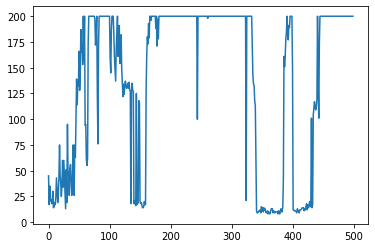

In [26]:
import matplotlib.pyplot as plt
plt.plot(reward_history)

In [28]:
from PIL import Image
try:
    env = gym.make('CartPole-v0').unwrapped
    frames = []
    DONE = False
    state = env.reset()
    state = torch.tensor(state).float()
    if use_cuda:
        state = torch.tensor(state).float()
    for t in count():
        env.render()
        frames.append(Image.fromarray(env.render(mode='rgb_array')))
        action = torch.argmax(network(state))
        next_state , reward , done , _ = env.step(action.item())
        state = torch.tensor(next_state).float()
        if use_cuda:
            state = state.cuda()
        if t >= 200:
            print('done')
            break
finally:
    env.close()
    with open('play_result.gif','wb') as f:
        im = Image.new('RGB', frames[0].size)
        im.save(f, save_all=True, append_images=frames)


done


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

In [2]:
import gym
env = gym.make('LunarLander-v2')

In [3]:
initial_state = env.reset()
random_action = env.action_space.sample()
observation, reward, done, info = env.step(random_action)

In [7]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

In [8]:
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

In [9]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

In [12]:
import math

In [13]:
agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 1        # 總共更新 400 次

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0

        while True:

            action, log_prob = agent.sample(state)
            next_state, reward, done, _ = env.step(action)
            print(math.exp(log_prob))
            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                rewards.append(np.full(total_step, total_reward))  # 設定同一個 episode 每個 action 的 reward 都是 total reward
                break

0.21456683038494642
0.25206111377259527
0.21528760871594887
0.22503787685282864
0.22470324937692743
0.30883846968287887
0.25328779487888375
0.3095194763021355
0.22350064828754157
0.2539837910029251
0.25320356690647433
0.3114649022989594
0.25344008008929486
0.3124465164249265
0.21328167315213903
0.31241336877412995
0.22050679822539393
0.22006906429886466
0.3134232284346834
0.21153924829811932
0.211864449987317
0.21903096411116796
0.25506726496595994
0.21290129645005113
0.31539905603661017
0.21742271867850177
0.31598715536561656
0.3158786130945514
0.21627749041146993
0.31640423348531604
0.2579270262668616
0.2110385190898975
0.21431817387548674
0.3188175185295566
0.21098350625795878
0.31869166747079897
0.2102055588376563
0.25830392502043237
0.31967555458039143
0.21041718371453114
0.25710842062563133
0.2562004972697262
0.21255233115946856
0.3226614408627945
0.3226625178633436
0.3226457093716822
0.20833325976977618
0.2105793369217034
0.207410840163223
0.25867529965994995
0.21183778110760265

0.20574487568812538
0.2605303208314332
0.21153125451957006
0.257873562258278
0.32750434001071316
0.2124374027723127
0.2138276386634707
0.33199978446026734
0.33184234309597777
0.3315853902620988
0.3315615161740908
0.21241192784094837
0.2539273302506027
0.3351334219366294
0.334850887652672
0.3347640787003608
0.1967088026911989
0.3349380784651249
0.19597671440111736
0.3348887713477805
0.3534286990517707
0.22290264037543464
0.1763077174560814

